In [1]:
# Import Dependencies and Load File
import numpy
import os
import json
import pdfplumber


file_dir = r'../floor_plans/'
fps = os.listdir(file_dir)

print(fps)
print(fps[4])
floor_plan = pdfplumber.open(file_dir +fps[4]).pages[0]
im = floor_plan.to_image(resolution = 144)

['A1492010025.pdf', 'A1492010029.pdf', 'DataSet', 'DC2782010014.pdf', 'E1102007016.pdf', 'E1102007020.pdf', 'E1422010011.pdf', 'E1422010014.pdf', 'E1602007002.pdf', 'E1662010012.pdf', 'E1662010013.pdf', 'E1712007005.pdf', 'E1712007007.pdf', 'E1712007010.pdf', 'E1822010019.pdf', 'E1822010022.pdf', 'E1892007005.pdf', 'E1892007007.pdf', 'full fp.pdf', 'simple fp.pdf']
E1102007016.pdf


In [2]:
# file io for the jsonified data

def load_json():
    with open("../symbols/outlets.json", "r") as infile:
        file = json.load(infile)
    
    infile.close()
    return file

def save_json(d):    
    with open('../symbols/outlets.json', 'w') as outfile:
        json.dump(d, outfile, indent = 4)
        
    outfile.close()
    print("file saved!")
    
# serialise the symbol as an object in a JSON file.
# adds the template to the dictionary of templates which can then be jsonified
def add_sig(family, name, signature, d = None):
    # if there is no dict to add to
    if d == None:
        d = {family : {name : signature}}
    
    else:
        #if the family does not exist in the dict
        if family not in d.keys():
            d[family] = {name : signature}
        
        else:
            d[family][name] = signature # should existing values be overwritten?
    
    return d

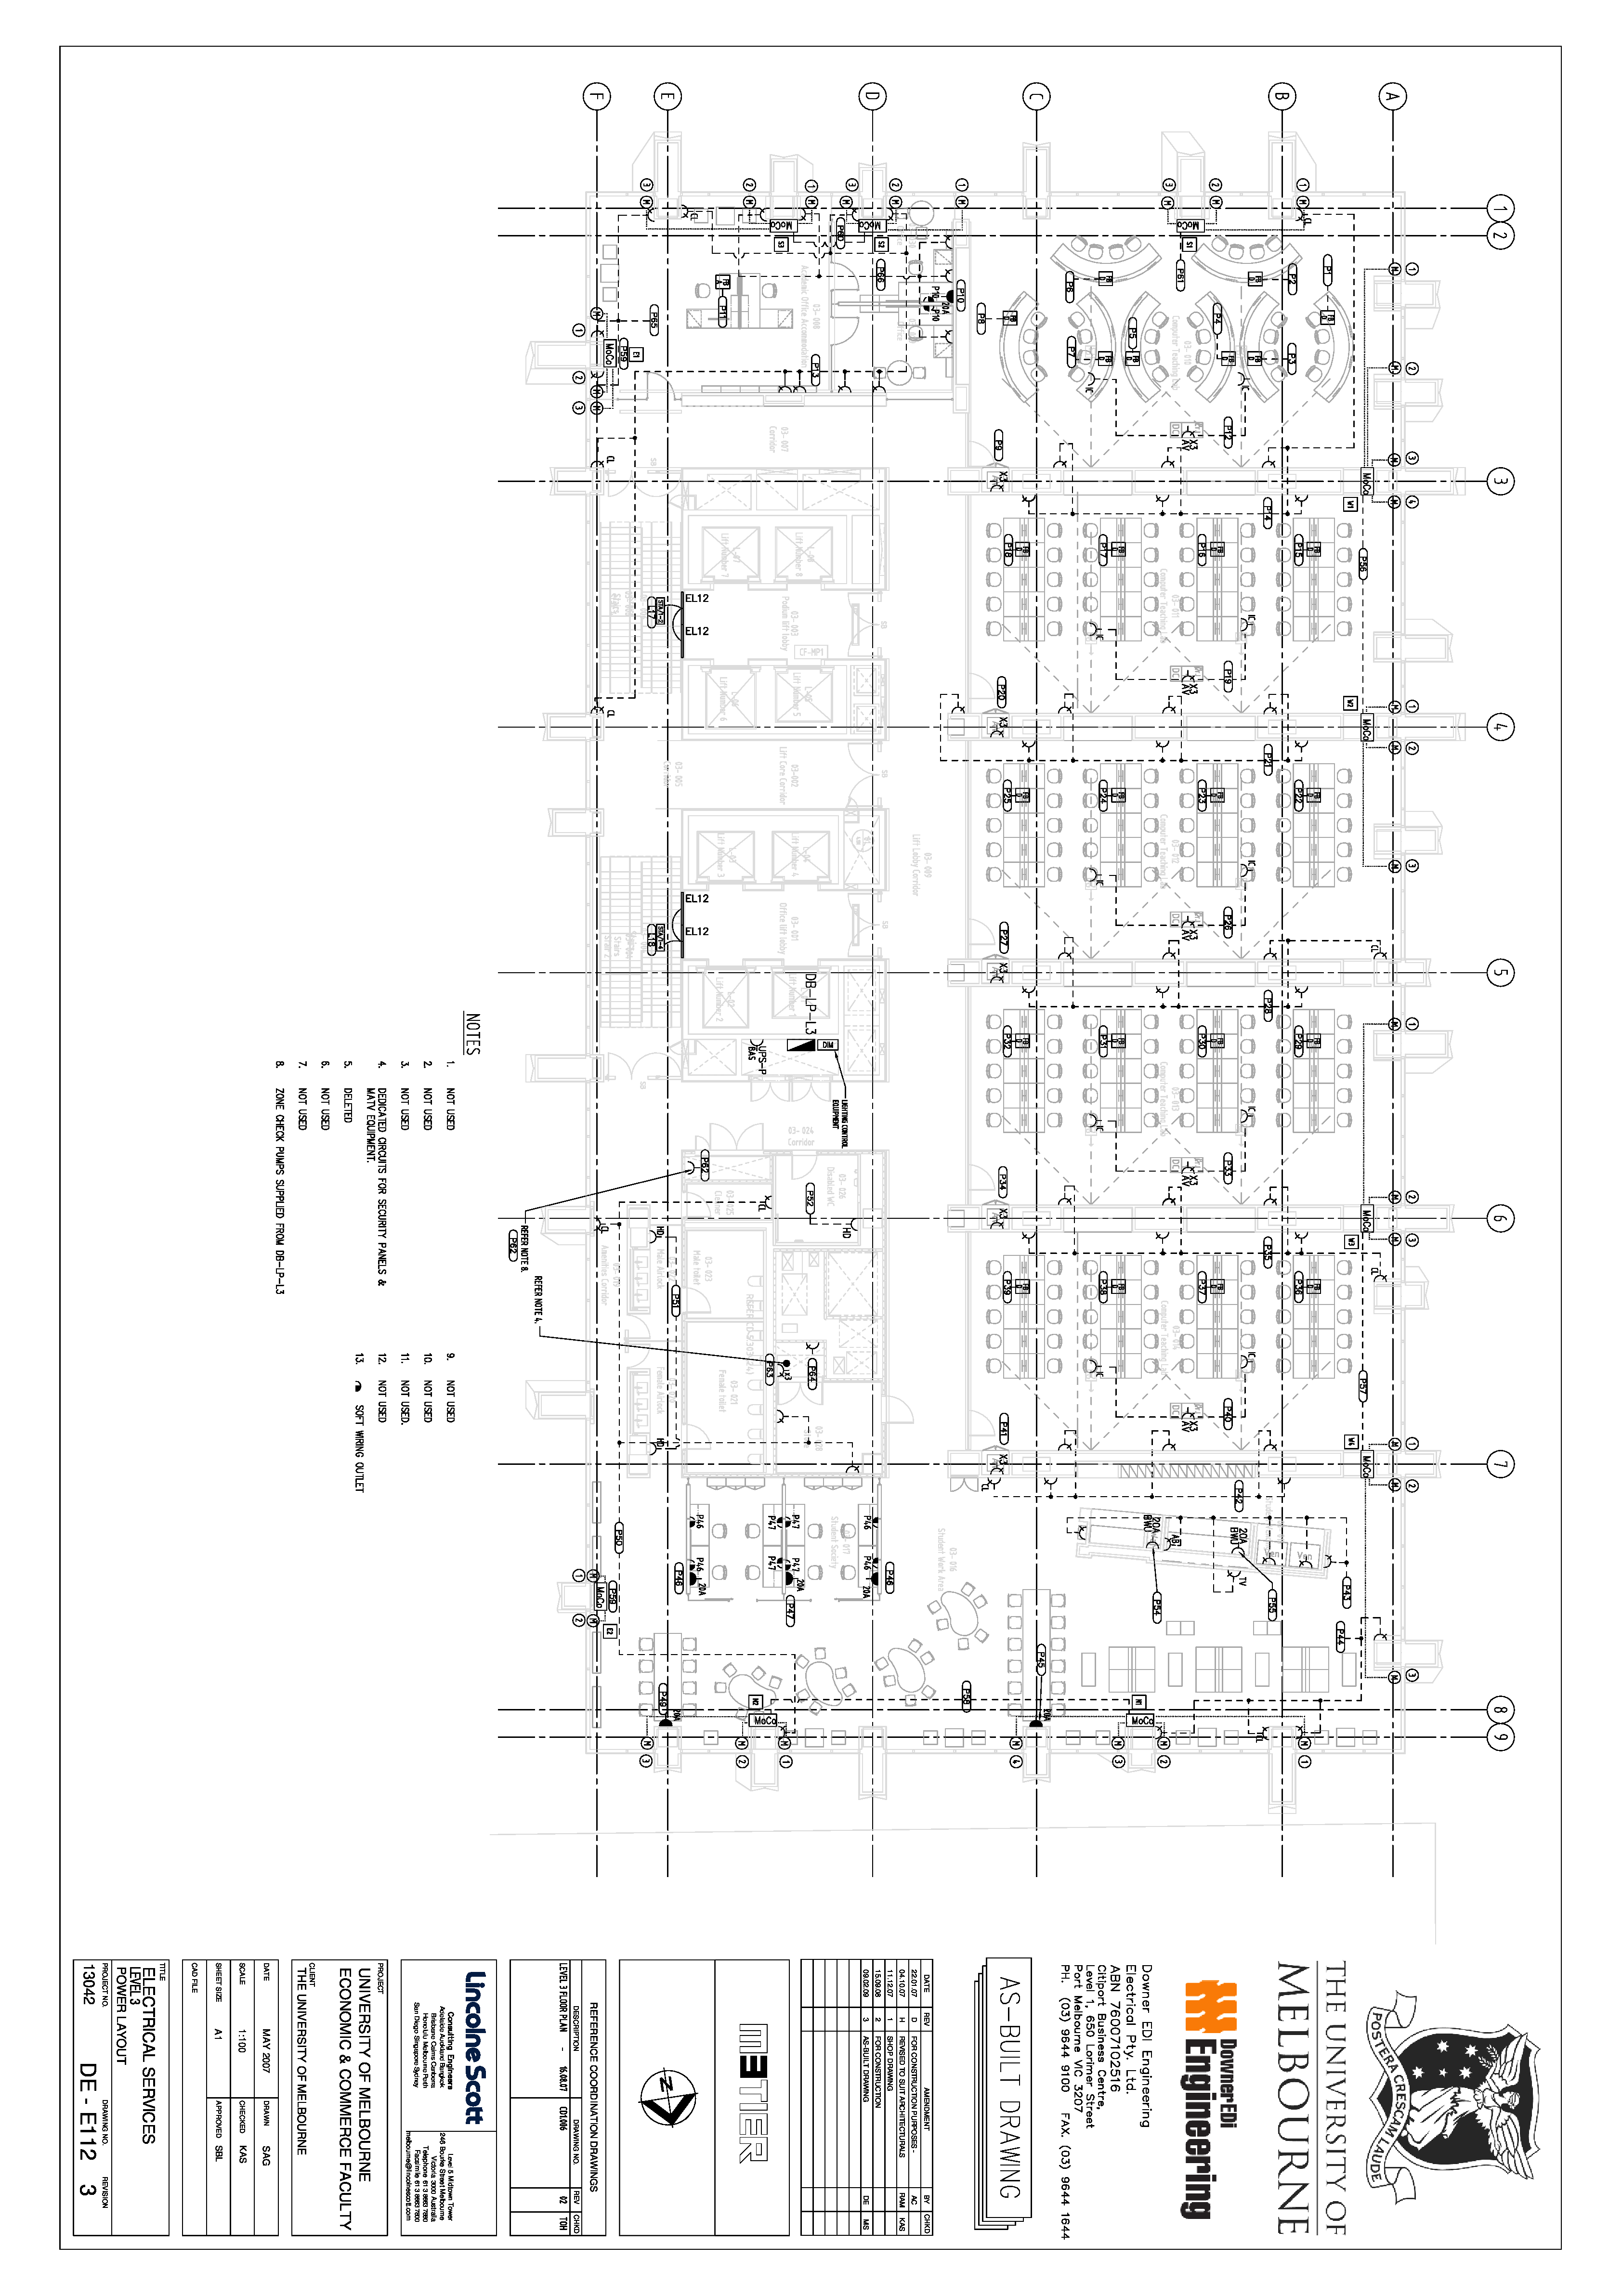

In [3]:
im

In [4]:
# Manually Search for an example of a symbol

# Searching for objects within an area of the pdf
# Finding an index of a specified symbol and used below
# This is assuming that all relevant objects are curves and not line
# May not always be the Case!

def find_all_segs(fp, xmin, xmax, ymin, ymax):
    segments = {}
    for i in range(0, len(fp.curves)):
        curve = fp.curves[i]
        
        if curve['y1'] > ymin and curve['y1'] < ymax:
            if curve['x1'] > xmin and curve['x1'] < xmax:
                segments[i] = curve
    
    return segments

segs = find_all_segs(floor_plan, 800, 850, 1100, 1180)
print(segs.keys())

dict_keys([619, 620, 621, 650, 3061, 3063, 3254, 3255, 3256, 9318, 9323, 9324, 9325, 9326, 9327])


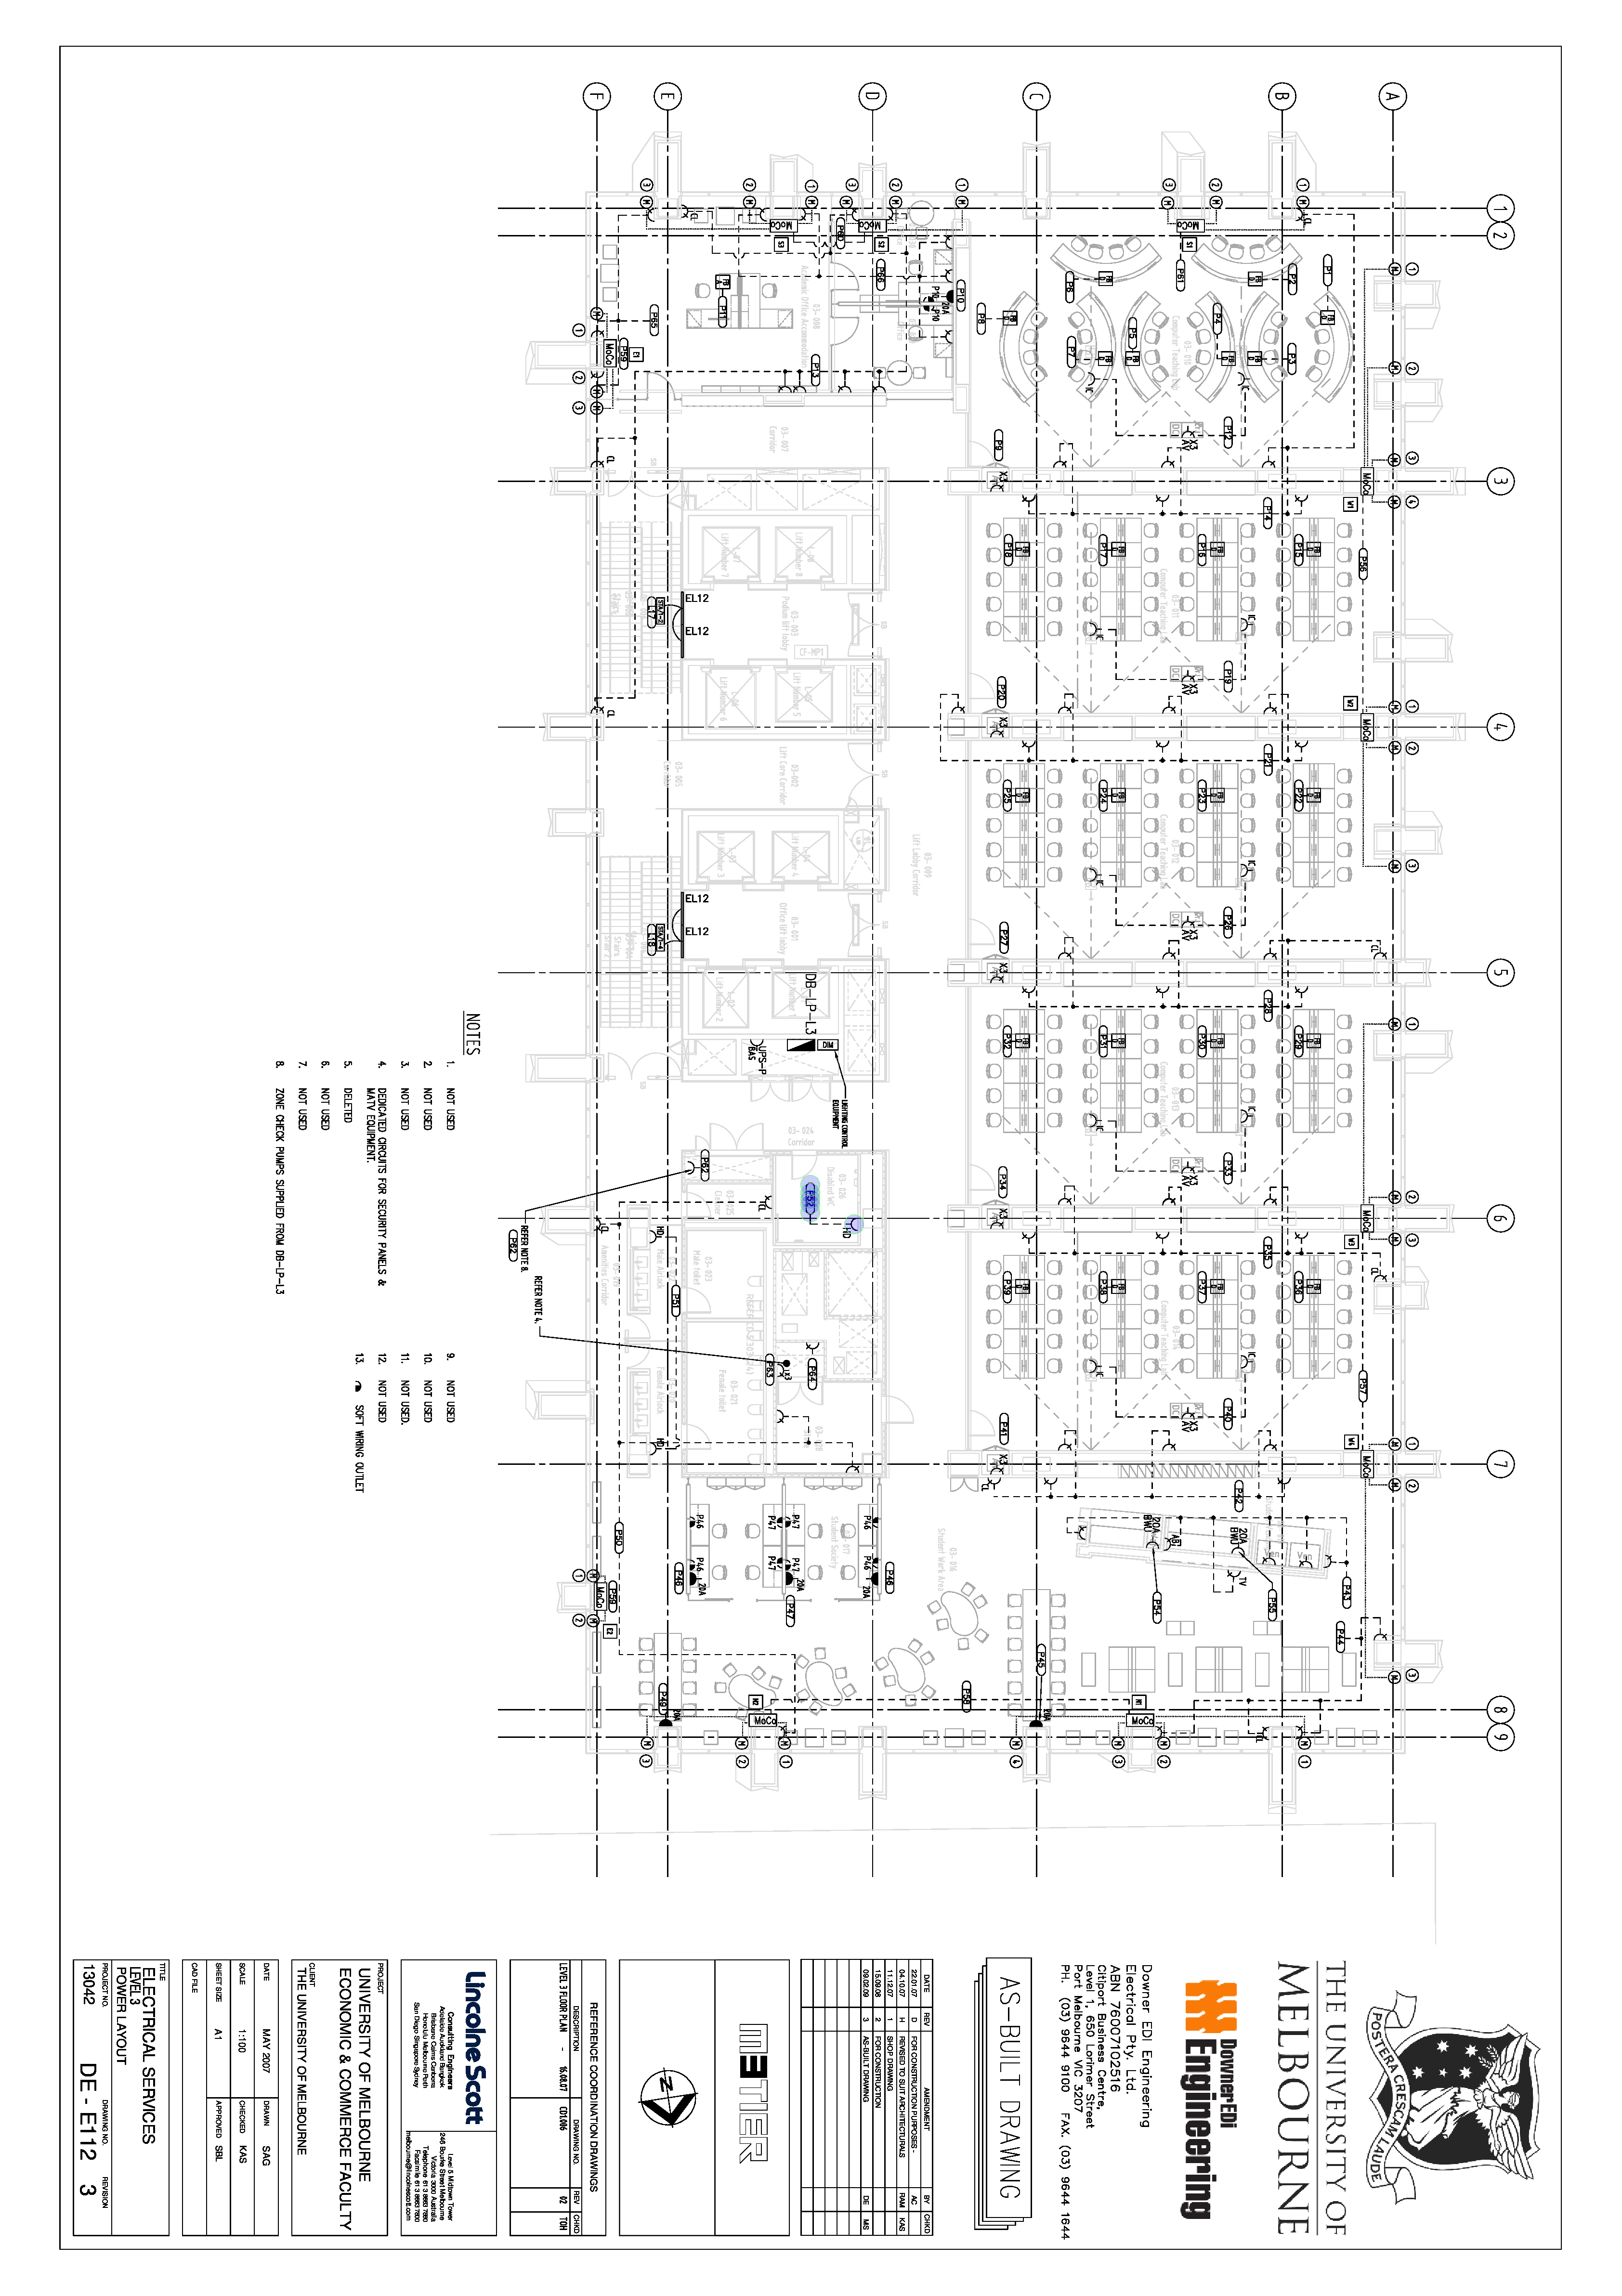

In [35]:
# confirm by visualising the floorplan with the symbol highlighted
im.reset()
for s in [9323, 9324, 9325, 9326, 9327, 9328]:
    im.draw_circle(floor_plan.curves[s], stroke = "#66FF66", radius = 10)
im

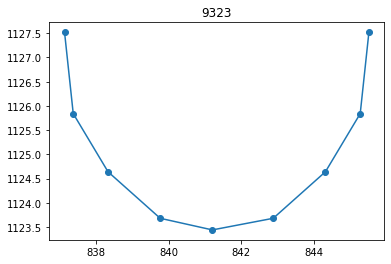

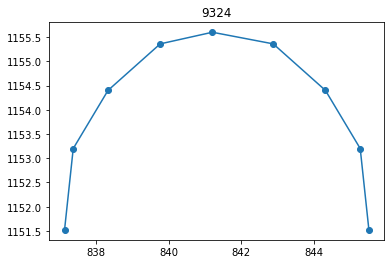

In [5]:
# looking for the correct shapes
import matplotlib.pyplot as plt

for n in [9323,9324]:
    sets = numpy.array(floor_plan.curves[n]['pts'])
    plt.scatter(sets[:, 0], sets[:, 1])
    plt.plot(sets[:, 0], sets[:, 1])
    plt.title(n)
    
    plt.show()

In [6]:
# new and improved reference values

#takes in two sets of coordinates and returns a floating point value
def euc_dist(a, b):    
    d = numpy.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)
    return float(d)

# find the distance from the first point to all other points in the curve set and save them
# accepts a list of coord tuples and returns a list of floating point values 
def find_distances(c_list):
    d_list = []
    base = c_list[0]['points'][0]
    for c in c_list:
        points = c['points']
        for i in range(0, len(points)):
            d_list.append(euc_dist(base, points[i]))
        
    return d_list

In [7]:
# creates the template of the asset to be searched for
def create_symbol_sig(fp,idx, n_parts):
    ppoint = find_distances(fp.curves[idx:idx+n_parts])
    full_dict = {}
    full_dict['distances'] = ppoint
    full_dict['total_points'] = len(ppoint)
    full_dict['components'] = n_parts
    return full_dict

sig_0 = create_symbol_sig(floor_plan, 9323, 2)
sig_0

{'distances': [0.0,
  1.697056274847714,
  3.12,
  4.659957081347423,
  5.9421208335071745,
  6.92265844889086,
  7.754637322273686,
  8.331146379700694,
  8.4,
  25.42754412050051,
  26.945277879435572,
  27.82758343802063,
  28.429618358324827,
  28.410364306006354,
  27.964892275851877,
  26.906772381688594,
  25.681121470839237,
  24.0],
 'total_points': 18,
 'components': 2}

In [41]:
# adding a new symbol to the list
d_sig = load_json()
d_sig = add_sig("b", "01", create_symbol_sig(floor_plan, 9323, 2), d_sig)
save_json(d_sig)

file saved!
